# Sentiment Analysis of Tweets by Brand <a class="anchor" id="Top"></a>
#### Authors: Eddie Prado, Sally Heinzel, Valeria Viscarra Fossati, and Weston Shuken

![Header Image](/images/sentiment_analysis_header.png)

###### Image by SurveySensum

## Table of Contents
* [Overview](#Overview)
* [Business Opportunity](#Business_Opportunity)
* [Data & Methods](#Data_Methods)
* [Data Exploration](#Data_Exploration)
* [Data Modeling](#Data_Modeling)    
    * [Binary Predictor Modeling](#Binary)
        * [Baseline Models](#Binary_Baseline)
        * [Tuned Models](#Binary_Tuned)
    * [Multiclass Predictor Modeling](#Multiclass)
        * [Baseline Models](#Multiclass_Baseline)
        * [Tuned Models](#Multiclass_Tuned)
    * [Added Feature Modeling](#Added_features)
    * [Neural Networks](#Neural_Networks)
    * [Recurrent Neural Networks](#RNN)
* [Final Model](#Final_Model)
* [Results & Evaluation](#Results)
* [Online Application](#Online_App)
* [Recommendations](#Recommendations)
* [Next Steps](#Next_Steps)
* [Contact Us](#Contact)

## Overview <a class="anchor" id="Overview"></a>
Understanding brand and product reputation is difficult when only provided customer survey and review data. However, there is an abundance of social media responses to products and brands on various platforms. With these unofficial reviews and preferences towards products via tweets from Twitter, we can derive an overall sentiment towards your brand and products.

Our comany, ViaGoGo, can provide you with a state-of-the-art machine learning model that rates the product and brand sentiment based on users who tweet about your brand. We can provide you with real-time graphs showing the trends of user sentiment towards your brand and products.


## Business Opportunity <a class="anchor" id="Business_Opportunity"></a>

Companies have little insight into their overall brand reputation on social media platforms. Twitter can provide real-time, accurate analysis of brand reputation based on the sentiment analysis of tweets on Twitter. The word cloud below is an example of how Twitter users are talking about Google and Apple:

<img width="965" alt="Wordcloud" src="https://user-images.githubusercontent.com/79488205/154538264-a0b97af9-dbae-4081-a2e6-bac438df0994.png">

Our team of experts has built a Machine Learning model that uses Natural Language Processing to distinguish between positive and negative sentiment in Tweets. Using Google and Apple mentions on Twitter, we were able to classify sentiment to an 89% accuracy. 

This model will be used as an analytics tool for companies to access their products' popularity on Twitter without having to access Twitter API. 


## Data & Methods <a class="anchor" id="Data_Methods"></a>
The dataset comes from Crowdflower via [data.world](https://data.world/crowdflower/brands-and-product-emotions) *Created: August 30, 2013 by Kent Cavender-Bares*. The data contains over 9,000 tweets from Twitter users that evaluated multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed, they were also asked to say which brand or product was the target of that emotion. 

During our exploratory data analysis, we found that the data was not balanced, as shown by the graphs below:

![Sentiment Dashboard](https://user-images.githubusercontent.com/79488205/154533171-abf7f63c-6498-4082-9c98-16b1618f05e7.png)


In order to address this imbalance, we first used a binary classifier to predict if a tweet would have a negative or not negative response. We chose to use this binary classification because negative sentiment is much more insightful to a brand versus neutral or positive sentiment. An example of usage could be to monitor if the negative sentiment increases on a particular day, then we can use inferential analysis to find specific tweets that were affecting the rating.

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from nlp_preprocessing import VIA_GoGo
import seaborn as sns
import gensim
import pickle
from textblob import TextBlob

from tensorflow.keras.layers import Dropout, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

## Data EDA <a class="anchor" id="Data_Exploration"></a>

In [2]:
tweet_df = pd.read_csv('data/db_tweet_emotion.csv', encoding= 'unicode_escape')

In [3]:
tweet_df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
tweet = tweet_df['tweet_text']
directed = tweet_df['emotion_in_tweet_is_directed_at']
emotion = tweet_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [6]:
tweet_df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [7]:
tweet_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: float64

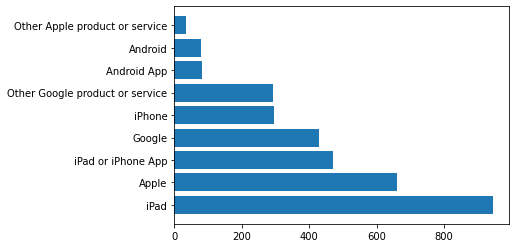

In [8]:
plt.barh(directed.value_counts().index, directed.value_counts().values);

In [9]:
directed.value_counts().sum()


3291

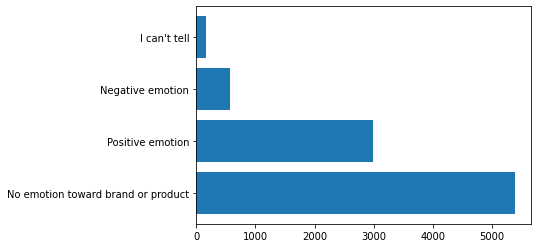

In [10]:
plt.barh(emotion.value_counts().index, emotion.value_counts().values);

In [11]:
emotion.value_counts()


No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

### Clean Up & Tokenize

In [12]:
# Instantiating tokenizer
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b")

# Create a list of stopwords in English
sw = stopwords.words('english')

In [13]:
sw.append('link')
sw.append('rt')
sw.append('sxsw')
sw.append('quot')

In [14]:
# instantiating Via_GoGo()
vg = VIA_GoGo()

# Creating a cleaned and shaped dataframe
clean_df = vg.clean_tokenizer(tweet_df, tokenizer, sw)
clean_df

,tweet_text,directed_at,emotion,emotion_num,brand,tweet_text_tokenized,joined_tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,-1,Apple,"[wesley83, 3g, iphone, hr, tweeting, rise_aust...",wesley83 3g iphone hr tweeting rise_austin dea...
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,1,Apple,"[jessedee, know, fludapp, awesome, ipad, iphon...",jessedee know fludapp awesome ipad iphone app ...
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,1,Apple,"[swonderlin, wait, ipad, also, sale]",swonderlin wait ipad also sale
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1,Apple,"[hope, year, festival, crashy, year, iphone, app]",hope year festival crashy year iphone app
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,1,Google,"[sxtxstate, great, stuff, fri, marissa, mayer,...",sxtxstate great stuff fri marissa mayer google...
...,...,...,...,...,...,...,...
9084,"@mention yup, but i don't have a third app yet...",NaN,No emotion toward brand or product,0,Google,"[mention, yup, third, app, yet, android, sugge...",mention yup third app yet android suggestion c...
9085,ipad everywhere. #sxsw {link},iPad,Positive emotion,1,Apple,"[ipad, everywhere]",ipad everywhere
9086,"wave, buzz... rt @mention we interrupt your re...",NaN,No emotion toward brand or product,0,Google,"[wave, buzz, mention, interrupt, regularly, sc...",wave buzz mention interrupt regularly schedule...
9087,"google's zeiger, a physician never reported po...",NaN,No emotion toward brand or product,0,Google,"[google, zeiger, physician, never, reported, p...",google zeiger physician never reported potenti...


In [15]:
# Maing columns that shows either positive (1) or not positive (0) sentiment 
clean_df['emotion_pos_not'] = clean_df['emotion_num']
clean_df['emotion_pos_not'] = clean_df['emotion_pos_not'].replace({-1:0})

In [16]:
clean_df.emotion_pos_not.value_counts(normalize=True)

0    0.672351
1    0.327649
Name: emotion_pos_not, dtype: float64

In [17]:
# Creating new DataFrame that does not inclued neutral tweeets
binary_df = clean_df[clean_df.emotion_num != 0]

In [18]:
clean_df.emotion_num.value_counts(normalize=True)

 0    0.609638
 1    0.327649
-1    0.062713
Name: emotion_num, dtype: float64

In [19]:
binary_df.emotion_num.value_counts(normalize=True)

 1    0.839346
-1    0.160654
Name: emotion_num, dtype: float64

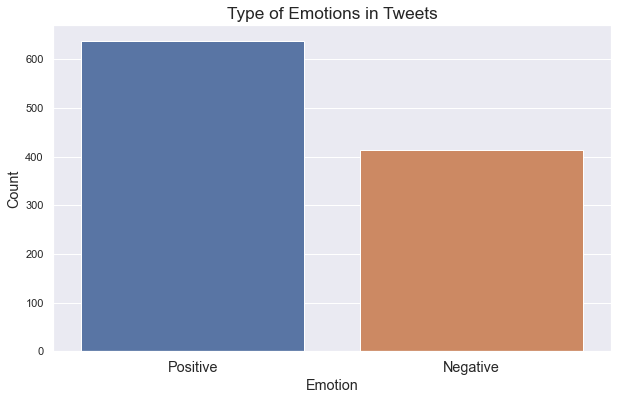

In [20]:
# visualize the counts of each emotion type
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,6))

ax = sns.countplot(
    data=binary_df, 
    x="directed_at",
    order=binary_df.brand.value_counts().index)

ax.set_title('Type of Emotions in Tweets',fontsize='x-large')
ax.set_xlabel('Emotion',fontsize='large')
ax.set_ylabel('Count',fontsize='large')
plt.xticks(range(2), ['Positive','Negative'],fontweight='light', fontsize='large')

plt.show();

In [21]:
from nltk import FreqDist

In [22]:
frequency_dist_all = FreqDist(clean_df["tweet_text_tokenized"].explode())

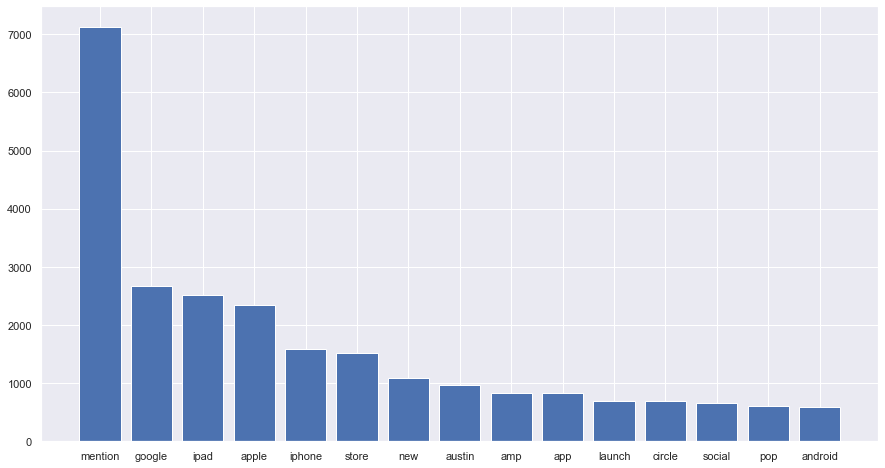

In [23]:
frequency_dist_all = FreqDist(clean_df["tweet_text_tokenized"].explode())

top_ten = list(zip(*frequency_dist_all.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

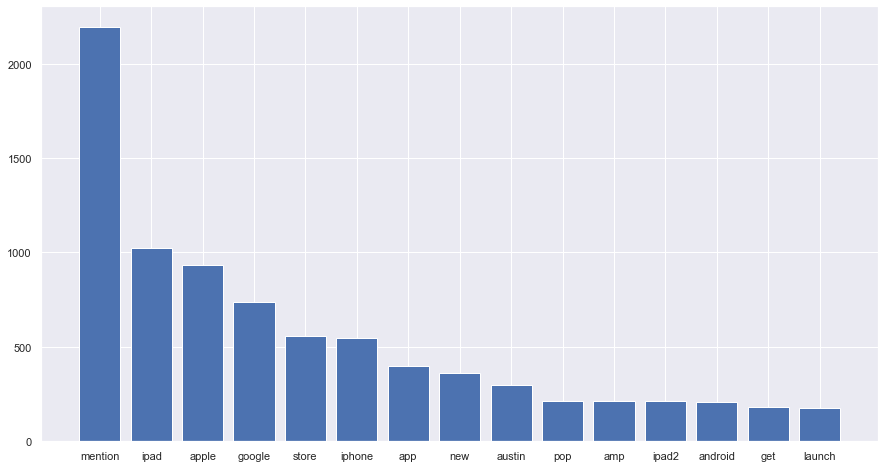

In [24]:
frequency_dist_positive = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == 1].explode())

top_ten = list(zip(*frequency_dist_positive.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

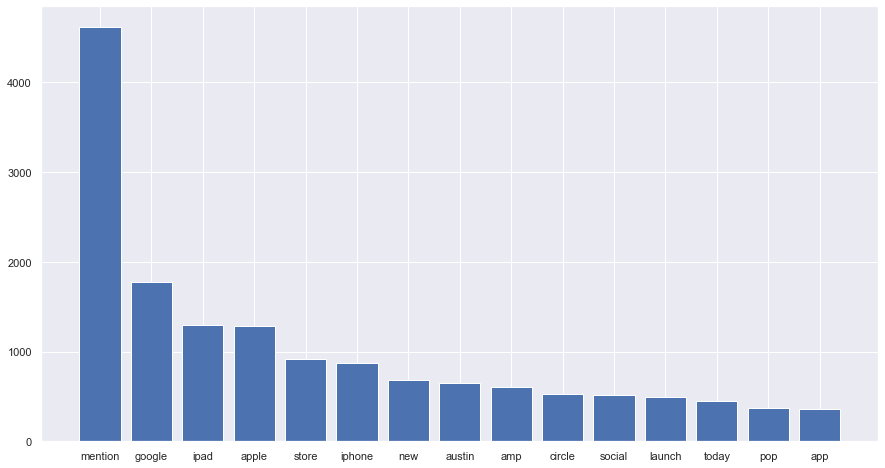

In [25]:
frequency_dist_neutral = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == 0].explode())

top_ten = list(zip(*frequency_dist_neutral.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

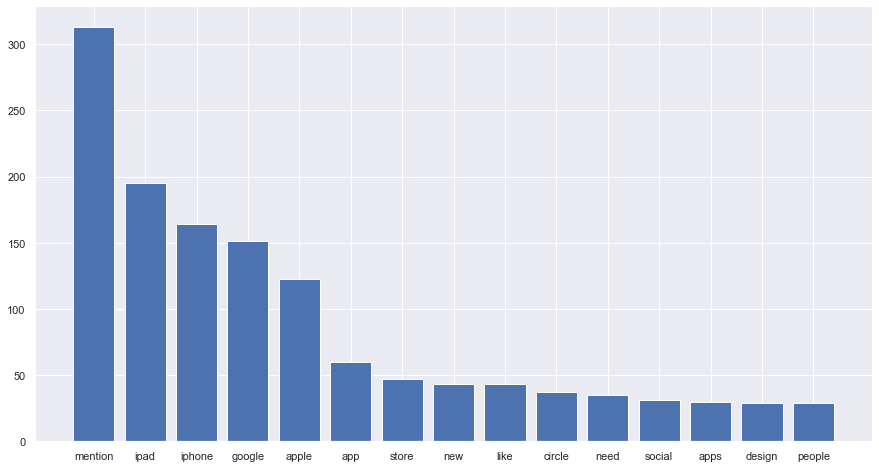

In [26]:
frequency_dist_negative = FreqDist(clean_df["tweet_text_tokenized"][clean_df["emotion_num"] == -1].explode())

top_ten = list(zip(*frequency_dist_negative.most_common(15)))
tokens = top_ten[0]
counts = top_ten[1]

plt.figure(figsize=(15, 8))
plt.bar(tokens, counts);

In [27]:
clean_df.directed_at.replace()

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9084    iPad or iPhone App
9085                  iPad
9086                  iPad
9087                  iPad
9088                  iPad
Name: directed_at, Length: 9089, dtype: object

In [28]:
apple_df = clean_df[clean_df.brand == 'Apple']

In [29]:
google_df = clean_df[clean_df.brand == 'Google']

## Data Modeling <a class="anchor" id="Data_Modeling"></a>

### Binary Data Predictor <a class="anchor" id="Binary"></a>

#### Baseline  <a class="anchor" id="Binary_Baseline"></a>

In [30]:
# Using Linear Support Vector Machine
sgd = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', SGDClassifier()),
              ])

# Using Naive Bayes
naive = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

# Using Logistic Regression
lin_reg = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression()),
              ])

# Using Random Forest
rfc = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier()),
              ])

baseline_models = [sgd, naive, lin_reg, rfc]


In [31]:
binary_metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

In [32]:
for model in baseline_models:   
    row = vg.run_model(model, binary_metric_table, apple_df['joined_tokens'], apple_df['emotion_pos_not'], 'binary_baseline_apple', join_str=False, plot_models=True)
    binary_metric_table = pd.concat([row])

binary_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline_apple,0.7128,0.7297,binary_baseline_apple
1,MultinomialNB()binary_baseline_apple,0.6969,0.6936,binary_baseline_apple
2,LogisticRegression()binary_baseline_apple,0.7155,0.7224,binary_baseline_apple
3,RandomForestClassifier()binary_baseline_apple,0.7194,0.7349,binary_baseline_apple


In [33]:
for model in baseline_models:   
    row = vg.run_model(model, binary_metric_table, google_df['joined_tokens'], google_df['emotion_pos_not'], 'binary_baseline_google', join_str=False)
    binary_metric_table = pd.concat([row])

binary_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline_apple,0.7128,0.7297,binary_baseline_apple
1,MultinomialNB()binary_baseline_apple,0.6969,0.6936,binary_baseline_apple
2,LogisticRegression()binary_baseline_apple,0.7155,0.7224,binary_baseline_apple
3,RandomForestClassifier()binary_baseline_apple,0.7194,0.7349,binary_baseline_apple
4,SGDClassifier()binary_baseline_google,0.7437,0.7356,binary_baseline_google
5,MultinomialNB()binary_baseline_google,0.7557,0.7383,binary_baseline_google
6,LogisticRegression()binary_baseline_google,0.7526,0.7517,binary_baseline_google
7,RandomForestClassifier()binary_baseline_google,0.7561,0.7597,binary_baseline_google


In [34]:
for model in baseline_models:   
    row = vg.run_model(model, binary_metric_table, clean_df['joined_tokens'], clean_df['emotion_pos_not'], 'binary_baseline_all', join_str=False)
    binary_metric_table = pd.concat([row])

binary_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline_apple,0.7128,0.7297,binary_baseline_apple
1,MultinomialNB()binary_baseline_apple,0.6969,0.6936,binary_baseline_apple
2,LogisticRegression()binary_baseline_apple,0.7155,0.7224,binary_baseline_apple
3,RandomForestClassifier()binary_baseline_apple,0.7194,0.7349,binary_baseline_apple
4,SGDClassifier()binary_baseline_google,0.7437,0.7356,binary_baseline_google
5,MultinomialNB()binary_baseline_google,0.7557,0.7383,binary_baseline_google
6,LogisticRegression()binary_baseline_google,0.7526,0.7517,binary_baseline_google
7,RandomForestClassifier()binary_baseline_google,0.7561,0.7597,binary_baseline_google
8,SGDClassifier()binary_baseline_all,0.7271,0.7505,binary_baseline_all
9,MultinomialNB()binary_baseline_all,0.7025,0.7259,binary_baseline_all


#### Tuned  <a class="anchor" id="Binary_Tuned"></a>

In [35]:
sgd_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])

naive_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

lin_reg_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(n_jobs=5)),
              ])

rfc_tuned = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100)),
              ])

baseline_tuned_models = [sgd_tuned, naive_tuned, lin_reg_tuned, rfc_tuned]

In [36]:
for model in baseline_tuned_models:   
    row = vg.run_model(model, binary_metric_table, apple_df['joined_tokens'], apple_df['emotion_pos_not'], 'baseline_tuned_apple', join_str=False)
    binary_metric_table = pd.concat([row])

binary_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline_apple,0.7128,0.7297,binary_baseline_apple
1,MultinomialNB()binary_baseline_apple,0.6969,0.6936,binary_baseline_apple
2,LogisticRegression()binary_baseline_apple,0.7155,0.7224,binary_baseline_apple
3,RandomForestClassifier()binary_baseline_apple,0.7194,0.7349,binary_baseline_apple
4,SGDClassifier()binary_baseline_google,0.7437,0.7356,binary_baseline_google
5,MultinomialNB()binary_baseline_google,0.7557,0.7383,binary_baseline_google
6,LogisticRegression()binary_baseline_google,0.7526,0.7517,binary_baseline_google
7,RandomForestClassifier()binary_baseline_google,0.7561,0.7597,binary_baseline_google
8,SGDClassifier()binary_baseline_all,0.7271,0.7505,binary_baseline_all
9,MultinomialNB()binary_baseline_all,0.7025,0.7259,binary_baseline_all


In [37]:
for model in baseline_tuned_models:   
    row = vg.run_model(model, binary_metric_table, google_df['joined_tokens'], google_df['emotion_pos_not'], 'baseline_tuned_google', join_str=False)
    binary_metric_table = pd.concat([row])

binary_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline_apple,0.7128,0.7297,binary_baseline_apple
1,MultinomialNB()binary_baseline_apple,0.6969,0.6936,binary_baseline_apple
2,LogisticRegression()binary_baseline_apple,0.7155,0.7224,binary_baseline_apple
3,RandomForestClassifier()binary_baseline_apple,0.7194,0.7349,binary_baseline_apple
4,SGDClassifier()binary_baseline_google,0.7437,0.7356,binary_baseline_google
5,MultinomialNB()binary_baseline_google,0.7557,0.7383,binary_baseline_google
6,LogisticRegression()binary_baseline_google,0.7526,0.7517,binary_baseline_google
7,RandomForestClassifier()binary_baseline_google,0.7561,0.7597,binary_baseline_google
8,SGDClassifier()binary_baseline_all,0.7271,0.7505,binary_baseline_all
9,MultinomialNB()binary_baseline_all,0.7025,0.7259,binary_baseline_all


In [38]:
for model in baseline_tuned_models:   
    row = vg.run_model(model, binary_metric_table, clean_df['joined_tokens'], clean_df['emotion_pos_not'], 'binary_tuned_all', join_str=False)
    binary_metric_table = pd.concat([row])

binary_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()binary_baseline_apple,0.7128,0.7297,binary_baseline_apple
1,MultinomialNB()binary_baseline_apple,0.6969,0.6936,binary_baseline_apple
2,LogisticRegression()binary_baseline_apple,0.7155,0.7224,binary_baseline_apple
3,RandomForestClassifier()binary_baseline_apple,0.7194,0.7349,binary_baseline_apple
4,SGDClassifier()binary_baseline_google,0.7437,0.7356,binary_baseline_google
5,MultinomialNB()binary_baseline_google,0.7557,0.7383,binary_baseline_google
6,LogisticRegression()binary_baseline_google,0.7526,0.7517,binary_baseline_google
7,RandomForestClassifier()binary_baseline_google,0.7561,0.7597,binary_baseline_google
8,SGDClassifier()binary_baseline_all,0.7271,0.7505,binary_baseline_all
9,MultinomialNB()binary_baseline_all,0.7025,0.7259,binary_baseline_all


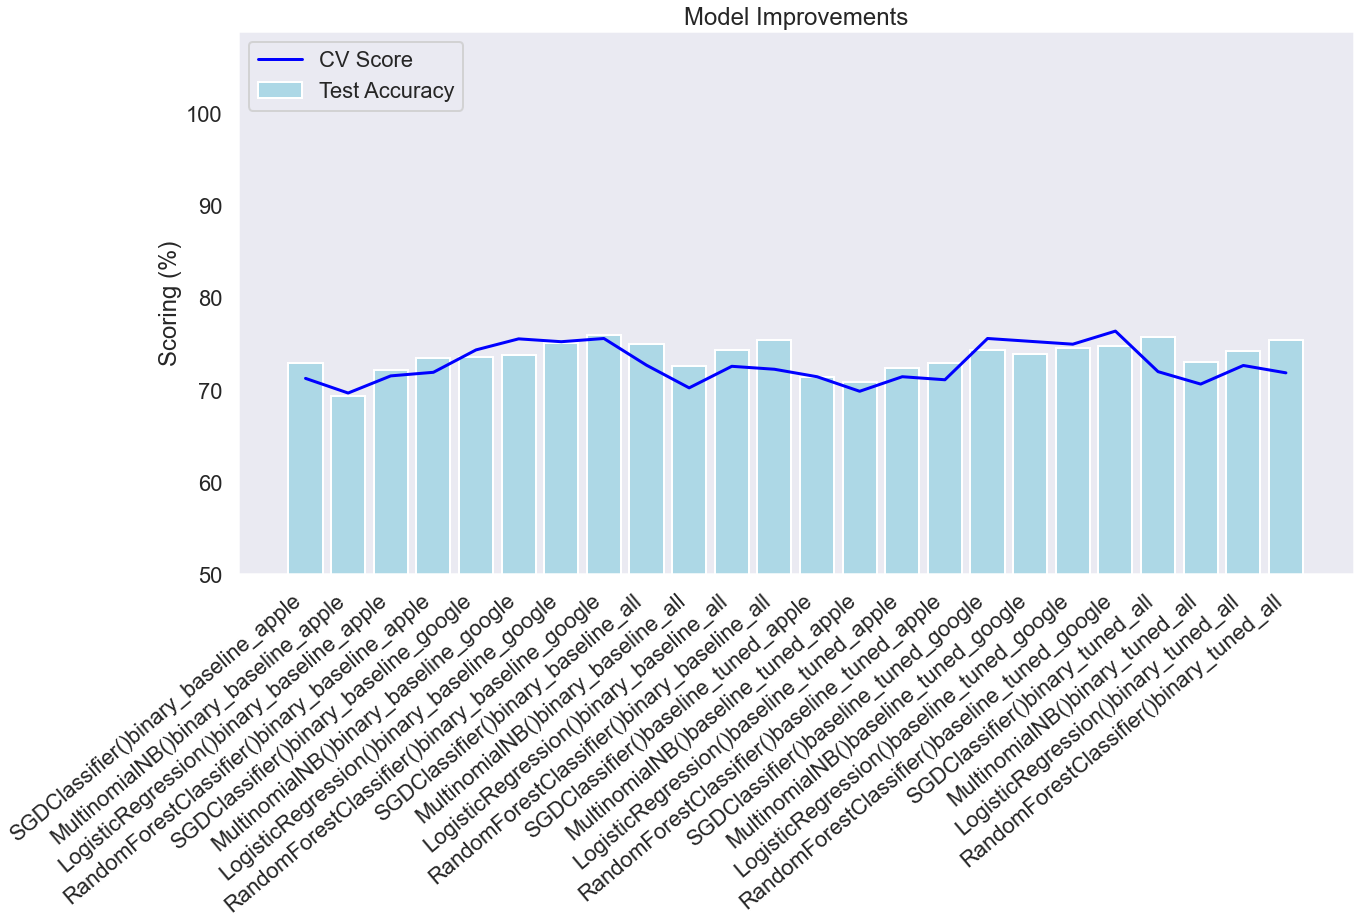

In [39]:
vg.plot_models(binary_metric_table)

### Multiclass Data Predictor  <a class="anchor" id="Multiclass"></a>

In [40]:
multiclass_metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

#### Baseline  <a class="anchor" id="Multiclasss_Baseline"></a>

In [41]:
sgd_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])

naive_mc = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

lin_reg_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='newton-cg', n_jobs=5)),
              ])

rfc_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100, class_weight='balanced')),
              ])

multiclass_models = [sgd_mc, naive_mc, lin_reg_mc, rfc_mc]

In [42]:
for model in multiclass_models:   
    row = vg.run_model(model, multiclass_metric_table, apple_df['joined_tokens'], apple_df['emotion_num'], 'baseline_multiclass_apple', join_str=False)
    multiclass_metric_table = pd.concat([row])

multiclass_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple


In [43]:
for model in multiclass_models:   
    row = vg.run_model(model, multiclass_metric_table, google_df['joined_tokens'], google_df['emotion_num'], 'baseline_multiclass_google', join_str=False)
    multiclass_metric_table = pd.concat([row])

multiclass_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
5,MultinomialNB()baseline_multiclass_google,0.7032,0.6916,baseline_multiclass_google
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
7,RandomForestClassifier()baseline_multiclass_go...,0.7139,0.6916,baseline_multiclass_google


In [44]:
for model in multiclass_models:   
    row = vg.run_model(model, multiclass_metric_table, google_df['joined_tokens'], google_df['emotion_num'], 'baseline_multiclass_all', join_str=False)
    multiclass_metric_table = pd.concat([row])

multiclass_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
5,MultinomialNB()baseline_multiclass_google,0.7032,0.6916,baseline_multiclass_google
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
7,RandomForestClassifier()baseline_multiclass_go...,0.7139,0.6916,baseline_multiclass_google
8,SGDClassifier()baseline_multiclass_all,0.7147,0.7009,baseline_multiclass_all
9,MultinomialNB()baseline_multiclass_all,0.7032,0.6916,baseline_multiclass_all


#### Tuned  <a class="anchor" id="Multiclass_Tuned"></a>

In [45]:
sgd_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer(smooth_idf=False)),
               ('clf', SGDClassifier())
              ])

naive_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(2,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

lin_reg_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', LogisticRegression(solver='newton-cg', n_jobs=5)),
              ])

rfc_tuned_mc = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
               ('tfidf', TfidfTransformer()),
               ('clf', RandomForestClassifier(max_depth=800, n_estimators=100, class_weight='balanced')),
              ])

multiclass_models_tuned = [sgd_tuned_mc, naive_tuned_mc, lin_reg_tuned_mc, rfc_tuned_mc]

In [46]:
for model in multiclass_models_tuned:   
    row = vg.run_model(model, multiclass_metric_table, apple_df['joined_tokens'], apple_df['emotion_num'], 'tuned_multiclass_apple', join_str=False)
    multiclass_metric_table = pd.concat([row])

multiclass_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
5,MultinomialNB()baseline_multiclass_google,0.7032,0.6916,baseline_multiclass_google
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
7,RandomForestClassifier()baseline_multiclass_go...,0.7139,0.6916,baseline_multiclass_google
8,SGDClassifier()baseline_multiclass_all,0.7147,0.7009,baseline_multiclass_all
9,MultinomialNB()baseline_multiclass_all,0.7032,0.6916,baseline_multiclass_all


In [47]:
for model in multiclass_models_tuned:   
    row = vg.run_model(model, multiclass_metric_table, google_df['joined_tokens'], google_df['emotion_num'], 'tuned_multiclass_google', join_str=False)
    multiclass_metric_table = pd.concat([row])

multiclass_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
5,MultinomialNB()baseline_multiclass_google,0.7032,0.6916,baseline_multiclass_google
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
7,RandomForestClassifier()baseline_multiclass_go...,0.7139,0.6916,baseline_multiclass_google
8,SGDClassifier()baseline_multiclass_all,0.7147,0.7009,baseline_multiclass_all
9,MultinomialNB()baseline_multiclass_all,0.7032,0.6916,baseline_multiclass_all


In [48]:
for model in multiclass_models_tuned:   
    row = vg.run_model(model, multiclass_metric_table, clean_df['joined_tokens'], clean_df['emotion_num'], 'tuned_multiclass_all', join_str=False)
    multiclass_metric_table = pd.concat([row])

multiclass_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
5,MultinomialNB()baseline_multiclass_google,0.7032,0.6916,baseline_multiclass_google
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
7,RandomForestClassifier()baseline_multiclass_go...,0.7139,0.6916,baseline_multiclass_google
8,SGDClassifier()baseline_multiclass_all,0.7147,0.7009,baseline_multiclass_all
9,MultinomialNB()baseline_multiclass_all,0.7032,0.6916,baseline_multiclass_all


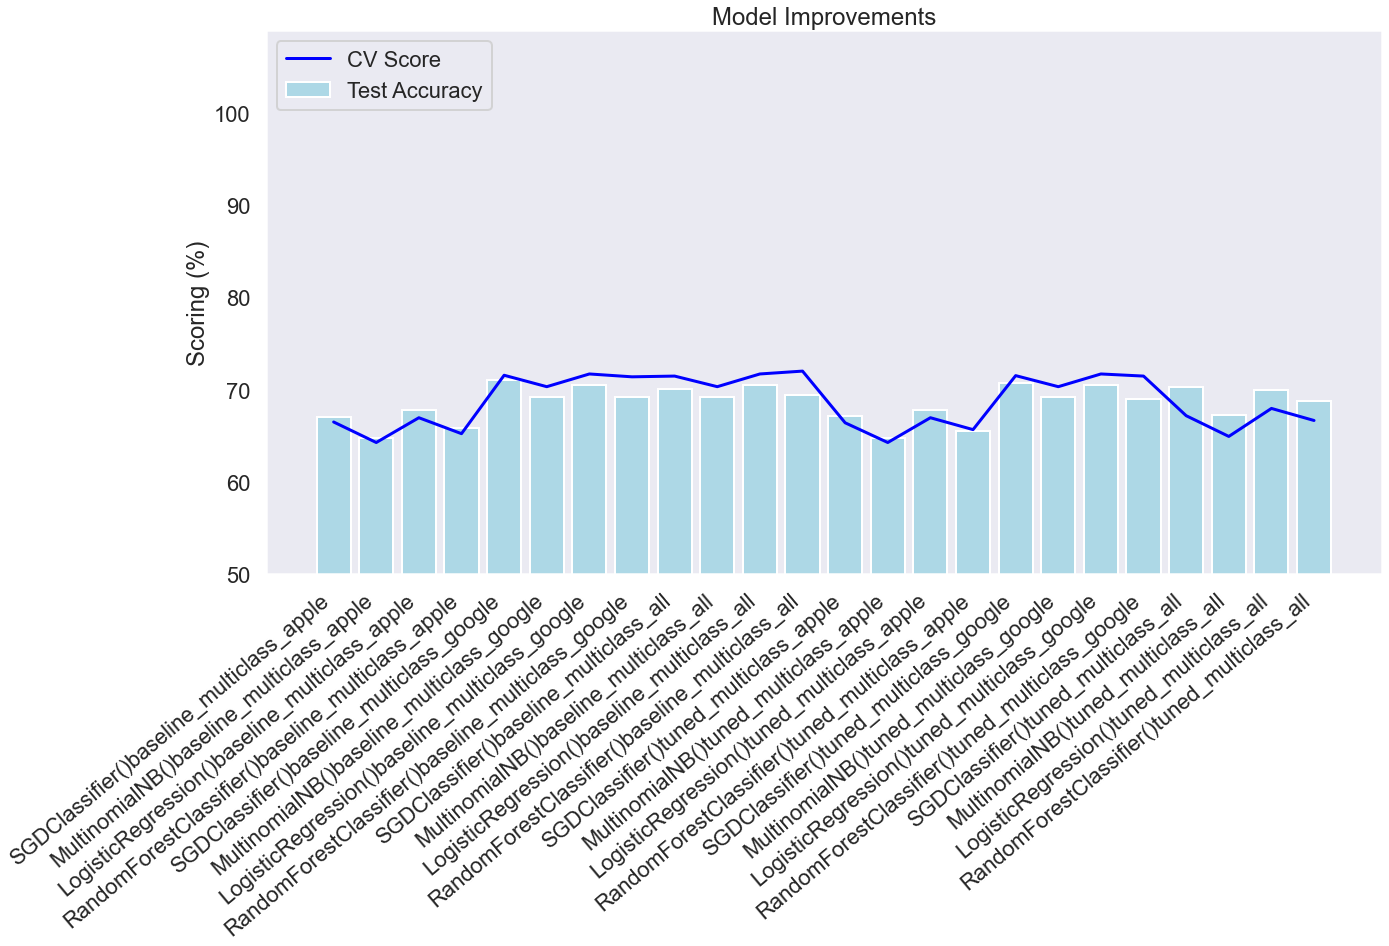

In [49]:
vg.plot_models(multiclass_metric_table)

### Adding Features <a class="anchor" id="Added_Features"></a>

In [50]:
addfeature_metric_table = pd.DataFrame(columns=['Model', 'CV Score', 'Test Accuracy', 'Type'])

In [51]:
from textblob import TextBlob

In [52]:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

clean_df['TextBlob_Polarity'] = clean_df['joined_tokens'].apply(getPolarity)

In [53]:
from afinn import Afinn
afinn = Afinn(language='en')

In [54]:
def getAffinscore(text):
    return afinn.score(text)
clean_df['Affin_score'] = clean_df['joined_tokens'].apply(getAffinscore)

In [55]:
sentiment_features = clean_df.loc[:,['TextBlob_Polarity', 'Affin_score']]

In [56]:
sentiment_features

,TextBlob_Polarity,Affin_score
0,-0.200000,-3.0
1,0.466667,7.0
2,0.000000,0.0
3,0.000000,2.0
4,0.800000,3.0
...,...,...
9084,0.000000,0.0
9085,0.000000,0.0
9086,0.000000,-1.0
9087,0.000000,0.0


In [57]:
clean_df['joined_tokens'] = clean_df['joined_tokens'].str.replace('\d+', '')

X = clean_df['joined_tokens']
countvec = CountVectorizer(min_df=5, ngram_range=(1,2), stop_words='english', strip_accents='unicode')


X_vec = countvec.fit_transform(X)

X_df = pd.DataFrame(X_vec.toarray(), columns=countvec.get_feature_names())
preprocess_features = sentiment_features.join(X_df, on=X_df.index)

In [58]:
preprocess_features.columns

Index(['TextBlob_Polarity', 'Affin_score', '______', 'a_', 'a_ edchat', 'aapl',
       'ab', 'abc', 'ability', 'able',
       ...
       'zazzle', 'zazzlesxsw', 'zazzlesxsw sxswi', 'zazzlsxsw',
       'zazzlsxsw uall', 'zlf', 'zomb', 'zombie', 'zomg', 'zomg mention'],
      dtype='object', length=3919)

In [62]:
clean_df['emotion_num'].shape

(9089,)

In [61]:
preprocess_features.shape

(9089, 3919)

In [64]:
sgd_feat = SGDClassifier()

rfc_feat = RandomForestClassifier(max_depth=100, n_estimators=100, class_weight='balanced')

feature_models = [sgd_feat, rfc_feat]

In [65]:
for model in feature_models:   
    row = vg.run_model(model, addfeature_metric_table, preprocess_features, clean_df['emotion_num'], 'feature_multiclass_all', join_str=False, pipeline=False)
    addfeature_metric_table = pd.concat([row])

addfeature_metric_table

,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()baseline_multiclass_apple,0.6649,0.6706,baseline_multiclass_apple
1,MultinomialNB()baseline_multiclass_apple,0.6426,0.6476,baseline_multiclass_apple
2,LogisticRegression()baseline_multiclass_apple,0.6695,0.6778,baseline_multiclass_apple
3,RandomForestClassifier()baseline_multiclass_apple,0.6522,0.6588,baseline_multiclass_apple
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
5,MultinomialNB()baseline_multiclass_google,0.7032,0.6916,baseline_multiclass_google
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
7,RandomForestClassifier()baseline_multiclass_go...,0.7139,0.6916,baseline_multiclass_google
8,SGDClassifier()baseline_multiclass_all,0.7147,0.7009,baseline_multiclass_all
9,MultinomialNB()baseline_multiclass_all,0.7032,0.6916,baseline_multiclass_all


### Word2Vec <a class="anchor" id="Word2Vec"></a>

In [67]:
model_w2v = gensim.models.Word2Vec(
            sentences=clean_df.tweet_text_tokenized,
            vector_size=200, # desired no. of features/independent variables 
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(clean_df.tweet_text_tokenized, total_examples=len(clean_df.tweet_text_tokenized), epochs=20)

(1393639, 1868820)

In [68]:
model_w2v.wv['iphone'].shape

(200,)

In [69]:
model_w2v.wv.most_similar(positive="iphone")

[('wew', 0.4895346462726593),
 ('desperate', 0.4808329641819),
 ('pushed', 0.4707336127758026),
 ('handy', 0.4661973714828491),
 ('yayrt', 0.4650564193725586),
 ('vufinders', 0.4634365439414978),
 ('merchant', 0.46336662769317627),
 ('loaded', 0.4565015733242035),
 ('purse', 0.4513796865940094),
 ('powermatteam', 0.4484415054321289)]

In [70]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

In [71]:
clean_df.reset_index(inplace=True, drop=True)

In [77]:
wordvec_arrays = np.zeros((len(clean_df.tweet_text_tokenized), 200))

for i in range(len(clean_df.emotion_num)):
    wordvec_arrays[i,:] = word_vector(clean_df.tweet_text_tokenized[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape   

(9089, 200)

In [76]:
clean_df.emotion_num.shape

(9089,)

In [74]:
sgd_word2vec = SGDClassifier()
rfc_word2vec = RandomForestClassifier(class_weight='balanced')

word2vec_models = [sgd_word2vec, rfc_word2vec]

In [78]:
for model in word2vec_models:   
    row = vg.run_model(model, addfeature_metric_table, wordvec_df, clean_df['emotion_num'], 'word2vec', join_str=False, pipeline=False)
    addfeature_metric_table = pd.concat([row])
addfeature_metric_table


,Model,CV Score,Test Accuracy,Type
0,SGDClassifier()feature_multiclass_all,0.6658,0.6832,feature_multiclass_all
1,SGDClassifier()feature_multiclass_all,0.6631,0.6740,feature_multiclass_all
2,RandomForestClassifier(class_weight='balanced'...,0.6818,0.6969,feature_multiclass_all
3,SGDClassifier()word2vec,0.6401,0.6516,word2vec
4,RandomForestClassifier(class_weight='balanced'...,0.6507,0.6718,word2vec


### Neural Network  <a class="anchor" id="Neural_Network"></a>

In [79]:
clean_df['emotion_num_nn'] = clean_df['emotion_num']

In [80]:
clean_df['emotion_num_nn'] = clean_df['emotion_num_nn'].replace(-1, 2)

In [81]:
X = clean_df['joined_tokens']
y =  clean_df['emotion_num_nn']

In [ ]:
# Append Feature, then vectorize

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [83]:
tfidf = TfidfVectorizer(ngram_range=(1,2), )

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print('Shape of train features tensor:', X_train_vec.shape)
print('Shape of test features tensor:', X_test_vec.shape)

Shape of train features tensor: (6816, 38060)
Shape of test features tensor: (2273, 38060)


In [84]:
print('Shape of train label tensor:', y_train.shape)
print('Shape of test label tensor:', y_test.shape)

Shape of train label tensor: (6816,)
Shape of test label tensor: (2273,)


In [87]:
model = Sequential()
model.add(layers.Dense(300, input_dim=(38060), activation='relu' ))
model.add(Dropout(.5))
# model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [88]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_vec, y_train, epochs=6, batch_size=100, validation_split=.20, verbose=1)

Train on 5452 samples, validate on 1364 samples
Epoch 1/6
5452/5452 [==============================] - 7s 1ms/sample - loss: 0.9276 - accuracy: 0.5930 - val_loss: 0.7797 - val_accuracy: 0.6327
Epoch 2/6
5452/5452 [==============================] - 7s 1ms/sample - loss: 0.6910 - accuracy: 0.6799 - val_loss: 0.7152 - val_accuracy: 0.6804
Epoch 3/6
5452/5452 [==============================] - 6s 1ms/sample - loss: 0.4904 - accuracy: 0.8362 - val_loss: 0.7106 - val_accuracy: 0.6811
Epoch 4/6
5452/5452 [==============================] - 6s 1ms/sample - loss: 0.3110 - accuracy: 0.8955 - val_loss: 0.7473 - val_accuracy: 0.6745
Epoch 5/6
5452/5452 [==============================] - 6s 1ms/sample - loss: 0.2048 - accuracy: 0.9296 - val_loss: 0.8015 - val_accuracy: 0.6686
Epoch 6/6
5452/5452 [==============================] - 6s 1ms/sample - loss: 0.1474 - accuracy: 0.9463 - val_loss: 0.8510 - val_accuracy: 0.6620


In [89]:
results = model.evaluate(X_test_vec, y_test, batch_size=10)
print("test loss, test acc:", results)

2273/2273 [==============================] - 2s 728us/sample - loss: 0.8448 - accuracy: 0.6854
test loss, test acc: [0.8447981084358099, 0.68543774]


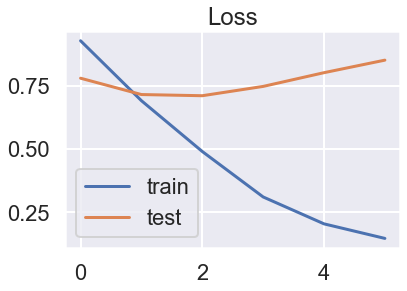

In [90]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

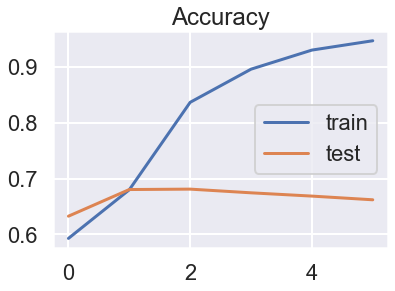

In [91]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Recurrent Neural Network w/ LSTM <a class="anchor" id="RNN"></a>

In [92]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(clean_df['joined_tokens'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8531 unique tokens.


In [93]:
X = tokenizer.texts_to_sequences(clean_df['joined_tokens'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9089, 250)


In [94]:
Y = pd.get_dummies(clean_df['emotion_num']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (9089, 3)


In [95]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=5)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7271, 250) (7271, 3)
(1818, 250) (1818, 3)


In [96]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(4))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', 
                                                                  patience=3, min_delta=0.0001)])

Train on 6543 samples, validate on 728 samples
Epoch 1/5


2022-02-18 08:35:19.655889: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_6653_7138_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_7290' and '__inference___backward_cudnn_lstm_with_fallback_6352_6534' both implement 'lstm_28745fd4-66f8-43f0-8ee0-923a150ce653' but their signatures do not match.


6528/6543 [============================>.] - ETA: 0s - loss: 0.9287 - accuracy: 0.6048

2022-02-18 08:35:51.859433: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_7800' and '__inference_standard_lstm_7800_specialized_for_sequential_2_lstm_StatefulPartitionedCall_at___inference_distributed_function_8178' both implement 'lstm_65afe36a-e7b5-4bcf-999f-7d6414453374' but their signatures do not match.


6543/6543 [==============================] - 34s 5ms/sample - loss: 0.9285 - accuracy: 0.6049 - val_loss: 0.8472 - val_accuracy: 0.5989
Epoch 2/5
6543/6543 [==============================] - 31s 5ms/sample - loss: 0.7829 - accuracy: 0.6494 - val_loss: 0.7757 - val_accuracy: 0.6305
Epoch 3/5
6543/6543 [==============================] - 31s 5ms/sample - loss: 0.6515 - accuracy: 0.7448 - val_loss: 0.7453 - val_accuracy: 0.6566
Epoch 4/5
6543/6543 [==============================] - 31s 5ms/sample - loss: 0.5251 - accuracy: 0.8131 - val_loss: 0.7535 - val_accuracy: 0.6525
Epoch 5/5
6543/6543 [==============================] - 31s 5ms/sample - loss: 0.4371 - accuracy: 0.8498 - val_loss: 0.7759 - val_accuracy: 0.6552


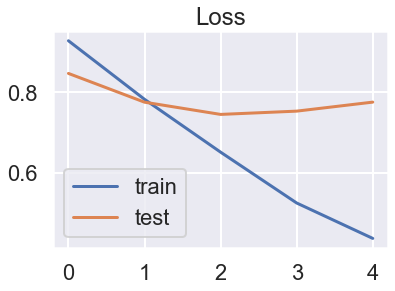

In [97]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

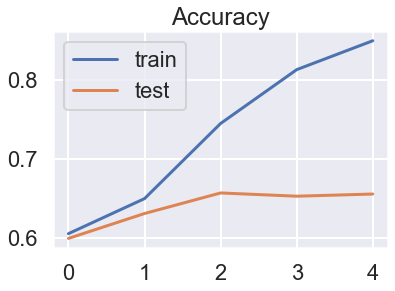

In [98]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### Final Model <a class="anchor" id="Final_Model"></a>

In [105]:
multiclass_metric_table.sort_values(by=['Test Accuracy'], ascending=False)

,Model,CV Score,Test Accuracy,Type
4,SGDClassifier()baseline_multiclass_google,0.7156,0.7103,baseline_multiclass_google
16,SGDClassifier()tuned_multiclass_google,0.7152,0.7076,tuned_multiclass_google
10,LogisticRegression()baseline_multiclass_all,0.7170,0.7049,baseline_multiclass_all
6,LogisticRegression()baseline_multiclass_google,0.7170,0.7049,baseline_multiclass_google
18,LogisticRegression()tuned_multiclass_google,0.7170,0.7049,tuned_multiclass_google
20,SGDClassifier()tuned_multiclass_all,0.6717,0.7026,tuned_multiclass_all
8,SGDClassifier()baseline_multiclass_all,0.7147,0.7009,baseline_multiclass_all
22,LogisticRegression()tuned_multiclass_all,0.6796,0.6991,tuned_multiclass_all
11,RandomForestClassifier()baseline_multiclass_all,0.7201,0.6943,baseline_multiclass_all
9,MultinomialNB()baseline_multiclass_all,0.7032,0.6916,baseline_multiclass_all


In [106]:
X_train, X_test, y_train, y_test = train_test_split(clean_df['joined_tokens'], 
                                                    clean_df['emotion_num'], 
                                                    test_size= 0.25,
                                                    random_state= 5)

In [107]:
final_preds = sgd_tuned_mc.predict(X_test)
final_trues = y_test

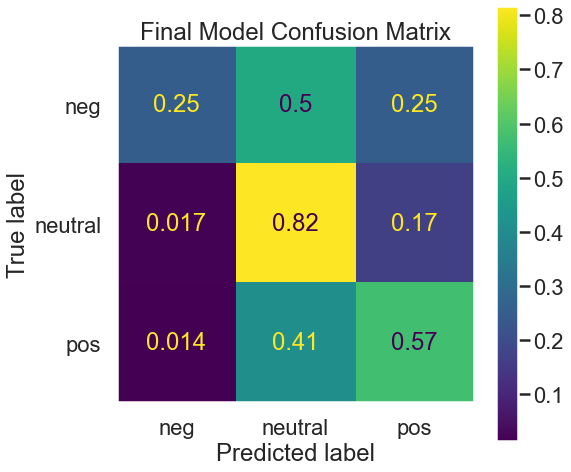

In [108]:
## FINAL MODEL
#sge_tuned_mc
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(sgd_tuned_mc, X_test, y_test, ax=ax, display_labels=['neg', 'neutral', 'pos'], normalize='true')
plt.title('Final Model Confusion Matrix')
plt.grid(False)
plt.show();

In [ ]:
pickle.dump(sgd_tuned_mc, open('final_clf.pkl', 'wb'))

## Results & Evaluation <a class="anchor" id="Results"></a>

Our baseline binary models classified tweets with an accuracy of 83 - 88%:

<img width="515" alt="Baseline Binary Models" src="https://user-images.githubusercontent.com/79488205/154533341-9aa712da-ded6-4b76-b809-75abea25f450.png">

Once we had this baseline, we continued to tune the models until we reached an accuracy score of 89% with our SGD Classifier model: 

<img width="504" alt="Tuned Binary Models" src="https://user-images.githubusercontent.com/79488205/154537919-16955719-995f-44bd-be1e-7ac72e7c70af.png">



## Online Application <a class="anchor" id="Online_App"></a>

We created an online application to demo the model's performance. The user can input a sample tweet and click the 'GoGo!' button, which will then return a sentiment score for the sample tweet of Positive, Negative, or Neutral.

![Online_App](images/online_app.jpg)

To demo the product, please visit this [link]().

[Return to top](#Top)

## Recommendations <a class="anchor" id="Recommendations"></a>
Being competitive in the 21st century means utilizing 21st-century tools. ViaGogo’s Twitter Sentiment Analysis, built using natural language processing, offers Twitter an opportunity to give their brand users an advantage in the marketplace. This product enables businesses to capture public reactions about their company and products in a far more timely and authentic manner than focus groups or surveys. It collects and analyzes real-time reactions in order for businesses to make effective decisions.

The Twitter Sentiment Analysis adds value to businesses in 3 main ways:
-	Brand Perception – track what people are saying about a company/product in real-time within a mercurial social media environment;
-	Market Research – identify and explore the sentiments directed at one’s competitors in order to develop strategies based on their successes and struggles;
-	Customer Service – pinpoint which brands, locations, or services are thriving in customer satisfaction and which ones need the most urgent attention.

By adopting ViaGogo’s Twitter Sentiment Analysis and offering it as a service for corporate users, Twitter will increase its utility and make itself an indispensable part of the modern business landscape.

[Return to top](#Top)

## Next Steps <a class="anchor" id="Next_Steps"></a>
ViaGogo in currently working on some new applications for its Twitter Sentiment Analysis. One product in development is the Positivity Rater. This tool gives users a positivity rating based on the analysis of the account’s past tweets. This can be useful to increase engagement among Twitters users. With so many people turned off by negative and harmful content, the Positivity Rater allows an individual to gauge how positive someone is when considering whether or not to follow them. We believe this will boost user activity and retain those who otherwise may stop using Twitter due to so much unwanted, pernicious content.

Another area ViaGoGo is actively working on is the creation of dashboards, which allow users to easily visualize sentiment analysis both in real-time and longitudinally. These dashboards will filter data on different dimensions, such as time frame, location, and product/service. It will also facilitate easy comparison of a given metric (for example, comparing the sentiments expressed towards 2 different branches or how sentiment about a product compares to this time last year).

Finally, ViaGoGo is already in production of a web app that allows users to write a tweet and see its sentiment rating before publishing it. This will ensure that the author strikes the appropriate tone with their tweet and can prevent thoughtless or poorly constructed tweets from entering the public domain. This feature will be valued by social media managers sitewide.

[Return to top](#Top)

---
## Contact <a class="anchor" id="Contact"></a>
#### For more information
Please contact the contributors to this analysis: 
[Eddie Prado]() |
[Sally Heinzel]() |
[Valeria Viscarra Fossati](https://www.linkedin.com/in/valeria-vf/) |
[Weston Shuken](https://www.linkedin.com/in/westonshuken/)

[Return to top](#Top)